In [1]:
%load_ext autoreload

# PSF
## Moffat2D

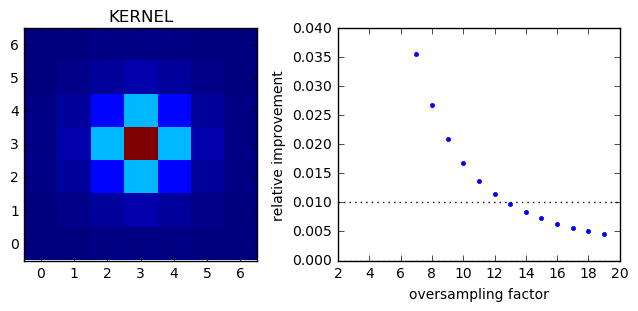

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%aimport imagemodels
p = imagemodels.SymmetricMoffat2D()

hpw = 3

p.x_0 = hpw
p.y_0 = hpw
p.fwhm = 1
p.alpha = 2
k = p.kernel(3)

nx,ny = 2*hpw+1,2*hpw+1
y, x = np.mgrid[:nx, :ny]
z = 0.0*x

k  = p(x,y)

# calculate the sum of the PSF w.r.t to no over sampling
maxsamp = 20
facto = np.linspace(1,maxsamp,maxsamp)
delta = []
for n in facto:
    kk = p._oversample_model(x,y,n,
          p.amplitude.value,p.x_0.value,p.y_0.value,p.fwhm.value,p.alpha.value)
    delta.append((k.sum()-kk.sum())/k.sum())

# convert the delta to a relative improvement over the preceding 
# oversampling factor
delta = np.array(delta)
delta = (delta[1:] - delta[:-1])/(delta[:-1])

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121)
ax.imshow(kk,interpolation='nearest',origin='lower')
ax.set_title('KERNEL')

ax = fig.add_subplot(122)
ax.plot(facto[:-1],delta,marker='.',ls='')
ax.axhline(0.,color='k',ls=':')
ax.set_ylabel('relative improvement')
ax.set_xlabel('oversampling factor')
ax.set_ylim((0.,0.04))
ax.axhline(0.01,color='k',ls=':')
#ax.imshow(kk,interpolation='nearest',origin='lower')

plt.show()
plt.close()